In [1]:
import csv
import math
import scipy
import sys
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from cmath import exp, pi
from scipy.io import wavfile as wav
from IPython.display import Audio, display, YouTubeVideo

# Zvuk

Zvuk je mehanički val koji nastaje titranjem fizikalnog tijela koje nazivamo **izvor zvuka**. Izvor u svojoj neposrednoj okolini mijenja tlak sredstva (medija), poremećaj tlaka prenosi se na susjedne čestice te omogućuje širenje zvuka sredstvom.

Osnovna svojstva zvuka su: 
-  frekvencija, 
-  amplituda, 
-  brzina, 
-  smjer.

### Frekvencija 

Frekvencija zvuka (oznaka: f) broj je titraja izvora u jednoj sekundi. Mjerimo ju u herzima (Hz).

Ljudsko uho raspoznaje zvukove frekvencija od 16 Hz do 20 kHz. Što smo stariji, teže prepoznajemo zvukove viših frekvencija.
Zvuk frekvencije ispod 16 Hz nazivamo **infrazvuk**, iznad 20 kHz **ultrazvuk**, a iznad 1 GHz **hiperzvuk**.

Generirajmo zvukove različitih frekvencija:

In [2]:
rate = 44100  # Number of frames(samples) per second (fps).
              # Read about reasons for choosing 44100 at [1]
    
duration = 2  # Duration of sound in seconds.

t = np.linspace(0., duration, int(rate*duration))

In [3]:
def synth(f): 
    '''Function synth synthesizes and reproduces the sound of given frequency.'''
    x = np.sin(2 * np.pi * f * t) 
    display(Audio(x, rate=rate))

In [4]:
synth(440)

Zanimljivosti:
-  frekvencija 440 Hz uzima se kao frekvencija štimanja većine orkestara (ton a1)
-  orkestri u Hrvatskoj (i većini Europe) štimaju se na 442 Hz
-  neki orkestri na Kubi štimaju se na 436 Hz kako bi im duže trajale žice jer si ne mogu priuštiti često mijenjati ih na instrumentima (žica frekvencije 436 Hz manje je nategnuta od žice 440 Hz pa teže puca)

Za više informacija o mijenjanju standarda frekvencije štimanja kroz povijest pogledajte u [2]. 

Testirajmo možemo li čuti gornju i donju ogradu za frekvencije koje percipira ljudsko uho.

In [5]:
synth(16)

In [6]:
synth(20000)

Gornja granica za odrasle zapravo je u prosjeku između 15 i 17 kHz. Frekvencije veće od toga percipiraju uglavnom djeca (novorođenčad i iznad 20 kHz). Niske frekvencije percipiramo kao vibracije.

Moj raspon (približno): od 25 Hz do 18.2 kHz.

Za modeliranje zvuka koristi se funkcija sinus.

Predočimo slikama kako izgledaju zvukovi različitih frekvencija:

In [7]:
def sineWave(f):
    '''Function sineWave returns model for a sound with frequency f, duration of 1 second and 44100 fps.'''
    return np.sin(2 * np.pi * f * np.linspace(0, 1, rate))

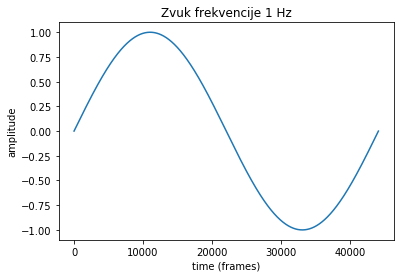

In [8]:
% matplotlib inline
plt.plot(sineWave(1))
plt.title("Zvuk frekvencije 1 Hz")
plt.xlabel("time (frames)")
plt.ylabel("amplitude")
plt.show()

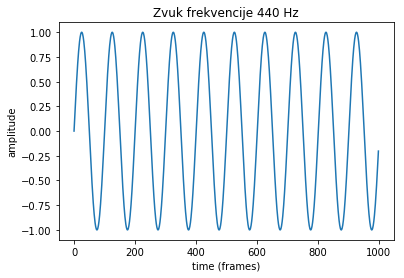

In [9]:
# Plotting first 1000 frames because 44100 frames look too dense on a plot to distinguish anything.
plt.plot(sineWave(440)[:1000])
plt.title("Zvuk frekvencije 440 Hz")
plt.xlabel("time (frames)")
plt.ylabel("amplitude")
plt.show()

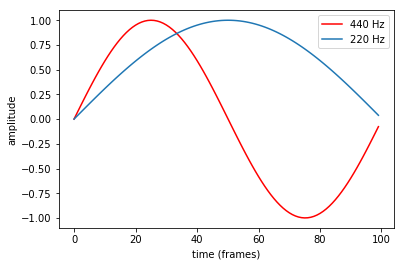

In [10]:
fig1, ax1 = plt.subplots()

ax1.plot(sineWave(440)[:100], color='red', label='440 Hz')
ax1.plot(sineWave(220)[:100], label='220 Hz')

ax1.set_xlabel("time (frames)")
ax1.set_ylabel("amplitude")

ax1.legend()

---

Sve zvukove koje smo do sad modelirali pomoću sinusa čujemo kao jedan 'čisti' ton. 

Kako modelirati zvuk akorda (istovremeno zvučanje tri tona)? 
Zbrojimo sinuse! Npr.

In [40]:
x = sineWave(440) + sineWave(554.37) + sineWave(659.25)
Audio(x, rate=rate)

Prikažimo ovaj zvuk slikom:

Text(0.5,1,'Chord')

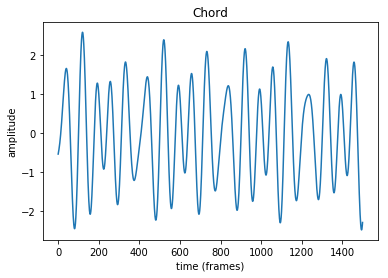

In [12]:
fig2, ax2 = plt.subplots()

ax2.plot(x[1500:3000])

ax2.set_xlabel("time (frames)")
ax2.set_ylabel("amplitude")
ax2.set_title("Chord")

Uočimo da funkcija koju smo dobili više nema oblik sinusa!

---

### Konstruktivna i destruktivna interferencija 

Dva vala su **koherentna** ako imaju:
-  konstantnu razliku u fazama
-  istu frekvenciju
-  isti oblik (waveform).

**Interferencija valova** je međudjelovanje dvaju ili više koherentnih valova koji istodobno prolaze kroz isti prostor. Amplituda u svakoj točki interferencije suma je amplituda svakog pojedinog vala u pripadnoj točki interferencije (princip superpozicije).

Do **konstruktivne interferencije** dolazi kada je razlika u fazama valova višekratnik od $2\pi$, a do **destruktivne** kada je razlika u fazama valova višekratnik od $\pi$.


Pogledajmo primjer destruktivne interferencije:


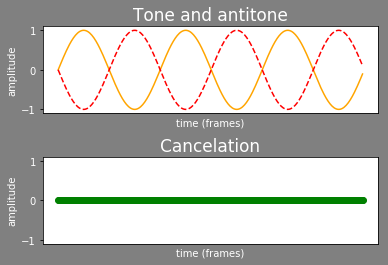

In [13]:
a = sineWave(440)
b = -sineWave(440)

fig3, (top, bottom) = plt.subplots(2, sharex=True, sharey=True)

fig3.set_facecolor('grey')  # Sets figure's background color.
fig3.subplots_adjust(hspace=0.5)  # Adjusts space between subplots.

top.plot(a[:300],'orange')
top.plot(b[:300],'r--')  # Plots red and ------- plot.

top.set_title("Tone and antitone", color='white', fontsize=17)
top.set_xlabel("time (frames)", color='white')
top.set_ylabel("amplitude", color='white')
top.tick_params(axis='x', bottom='off')


bottom.plot((a+b)[:300],'go')  # Green bold plot.

bottom.set_title("Cancelation", color='white', fontsize=17)
bottom.set_xlabel("time (frames)", color='white')
bottom.set_ylabel("amplitude", color='white')
bottom.tick_params(axis='x', bottom='off', labelbottom='off')  # Removing ticks from x axis. 

# Setting label colors.    
for label in top.yaxis.get_ticklabels():
    label.set_color('white')
    
for label in bottom.yaxis.get_ticklabels():
    label.set_color('white')

In [14]:
# To reproduce this "sound" we first need to tell numpy how to handle division by zero.
# In contrary, we get this warning:
# RuntimeWarning: invalid value encountered in true_divide
# scaled = np.int16(data/np.max(np.abs(data))*32767).tolist()
np.seterr(divide='ignore', invalid='ignore')

Audio(a+b, rate=rate)

*Zanimljivost*: Na principu destruktivne interferencije rade slušalice koje blokiraju buku.

### Buka

In [15]:
noise = [np.random.uniform(-1, 1) for t in np.arange(0, 5, 1/44100)]
Audio(noise, rate=rate)

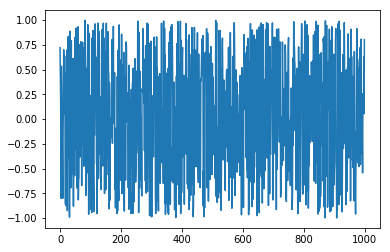

In [16]:
plt.plot(noise[:1000])
plt.show()

### Sonifikacija

Razne vizualizacije podataka poput grafova, histograma, bar plotova i sl. pomažu nam kako bismo podatke bolje razmjeli i lakše interpretirali. Sonifikacija se odnosi na primjenu zvukova (ali ne i govora) kako bismo predočili podatke.

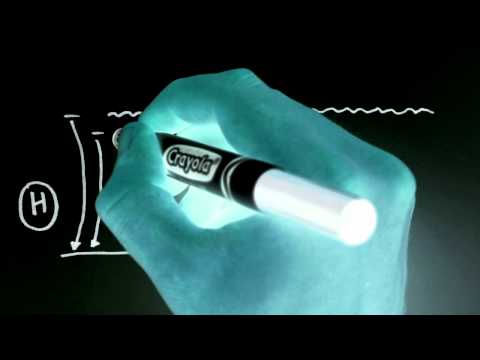

In [17]:
YouTubeVideo('qyi5SvPlMXc')

Poslušajmo kako zvuči promjena prosječne temperature Zemlje kroz povijest.

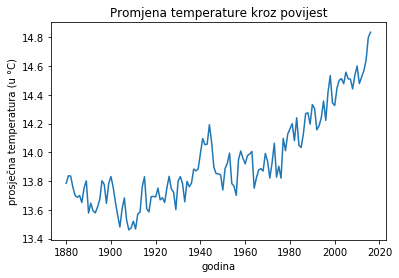

In [18]:
data = []
with open("global_annual_mean_temp_anomalies_land-ocean_1880-2016.csv") as fp:
    for row in csv.reader(fp):
        data.append(row)
        
time = [int(row[0]) for row in data]
temp = [float(row[2]) for row in data]


plt.plot(time, temp)
plt.title("Promjena temperature kroz povijest")
plt.xlabel("godina")
plt.ylabel("prosječna temperatura (u °C)")
plt.show()

In [19]:
data = []
for t in np.arange(0, 7, 1/44100):
    temp_index = math.floor(t/7 * len(temp))
    f = 6*(temp[temp_index] - min(temp))/(max(temp) - min(temp))
    data.append(math.sin(2 * math.pi * f * (16000 + 400 * t)))

Audio(data, rate=rate)

### Kratki pregled raznih mogućnosti za rad s audio fileovima

In [20]:
Audio('applause.wav')

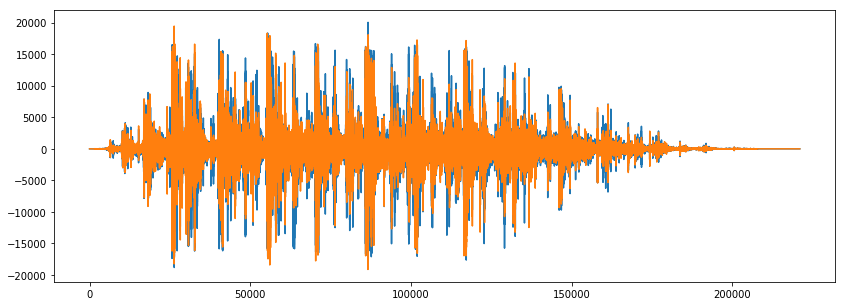

In [21]:
rate, data = wav.read('applause.wav')  # Reading of .wav file from folder.
%matplotlib inline
plt.figure(figsize=(14, 5))
plt.plot(data)
plt.show()

In [22]:
data.dtype  # 24-bit wav files are not supported.

dtype('int16')

In [23]:
data.shape  # (number_of_sample_points, channels)

(221022, 2)

Dobili smo da broj kanala iznosi 2 (stereo zvuk) što odgovara slici na kojoj imamo zvuk prikazan dvjema bojama (narančasta i plava) koje se skoro pa potpuno preklapaju.

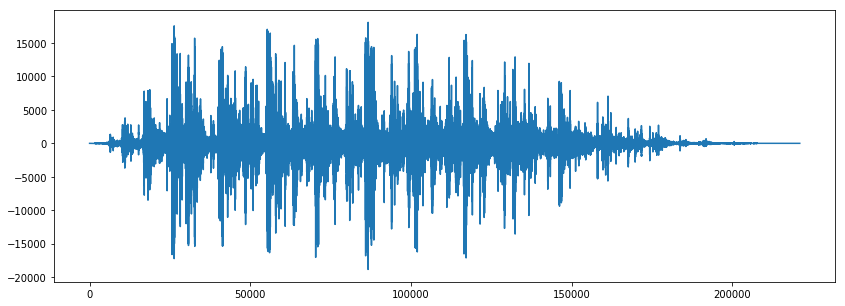

In [24]:
mono = np.mean(data, axis=1)  # We convert to mono by averaging the left and right channels.
plt.figure(figsize=(14, 5))
plt.plot(mono)
plt.show()

In [25]:
N = data.shape[0]
L = N / rate  # Duration of audio in seconds.
L

4.604625

#### Librosa - audio and music processing in Python

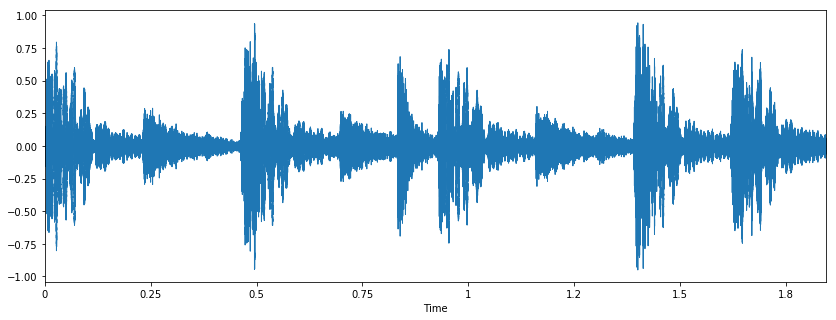

In [26]:
x, sr = librosa.load('beat.wav')
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [27]:
Audio(data=x, rate=sr)

In [28]:
x_slow = librosa.effects.time_stretch(x, 0.5)  # Slows down the audio.

In [29]:
Audio(data=x_slow, rate=sr)

In [30]:
librosa.output.write_wav('slower_beat.wav', x_slow, sr)  # Saving data to .wav file.

In [31]:
y, sr2 = librosa.load('button.wav')
Audio(data=y, rate=sr2)

In [32]:
y_shift = librosa.effects.pitch_shift(y, sr2, n_steps=4)  # Changing a pitch for 4 half-steps.
Audio(data=y_shift, rate=sr2)

## Fourierove transformacije 

**Diskretna Fourierova transformacija:**
$$X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}$$

**Inverzna diskretna Fourierova transformacija:**
$$x_n = \frac{1}{N}\sum_{k=0}^{N-1} X_k e^{i~2\pi~k~n~/~N}$$

U literaturi [6] nalazimo pojašnjenje diskretne Fourierove transformacije:

"This is a specific form of the FT applied to a time wave, typically a sound. Each sine/cosine  function  has  a  specified frequency  and  a  relative amplitude. These two parameters are used to build the frequency spectrum of the original time  wave. The  DFT  is  then  a  way  to  switch  from  the time domain to  the frequency domain"


In [33]:
sys.getrecursionlimit()

3000

In [34]:
def FFT(x):
    N = len(x)
    
    if N <= 1: 
        return x
    
    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")
        
    x_even = FFT(x[::2])
    x_odd =  FFT(x[1::2])
    r = range(N//2)
    T = [exp(-2j * pi * k / N) * x_odd[k] for k in r]
    
    [x_even[k] for k in r]
    y = ([x_even[k] + T[k] for k in r] +
           [x_even[k] - T[k] for k in r])
    return y

In [35]:
x2 = np.random.random(1024)
np.allclose(FFT(x2), np.fft.fft(x2))  # Comparing results of our FFT with numpy's fft.

True

In [36]:
def FFT_vectorized(x):
    """A vectorized, non-recursive version of FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]

    if N <= 1: 
        return x
    
    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")
    
    n = np.arange(N)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N)
    X = np.dot(M, x.reshape((N, -1)))
    
    while X.shape[0] < N:
        X_even = X[:, :X.shape[1] // 2]
        X_odd = X[:, X.shape[1] // 2:]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel()

In [37]:
np.allclose(FFT_vectorized(x2), np.fft.fft(x2))

True

In [38]:
# Comparing execution times of different implementations for FFT.
%timeit FFT(x2)
%timeit FFT_vectorized(x2)
%timeit np.fft.fft(x2)
%timeit scipy.fftpack.fft(x2)

10.3 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
92.5 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.8 µs ± 102 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
9.32 µs ± 30.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [39]:
y2 = np.random.random(1023)  # Not a power of 2.

%timeit np.fft.fft(y2)
%timeit scipy.fftpack.fft(y2)

55.4 µs ± 393 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
16.3 µs ± 394 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Primijetimo da je vrijeme izvršavanja veće kada se ne radi o potenciji broja 2.

Literatura:

[1] https://www.sweetwater.com/insync/7-things-about-sample-rate/ (Zadnje pristupljeno: 15. travnja 2018.)

[2] https://en.wikipedia.org/wiki/Concert_pitch (Zadnje pristupljeno: 15. travnja 2018.)

[3] https://musicinformationretrieval.com/ipython_audio.html (Zadnje pristupljeno: 15. travnja 2018.)

[4] https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/ (Zadnje pristupljeno: 15. travnja 2018.)

[5] https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/ (Zadnje pristupljeno: 15. travnja 2018.)

[6] https://cran.r-project.org/web/packages/seewave/vignettes/seewave_analysis.pdf (Zadnje pristupljeno: 15. travnja 2018.)